Oriented Keypoints:
X: 589, Y: 119, Orientation: 247.615478515625 degrees
X: 584, Y: 120, Orientation: 300.9600524902344 degrees
X: 599, Y: 123, Orientation: 11.310206413269043 degrees
X: 581, Y: 126, Orientation: 242.64892578125 degrees
X: 591, Y: 128, Orientation: 281.7901306152344 degrees
X: 603, Y: 129, Orientation: 261.8705139160156 degrees
X: 596, Y: 135, Orientation: 34.27965545654297 degrees
X: 591, Y: 139, Orientation: 95.4765625 degrees
X: 612, Y: 138, Orientation: 0.0 degrees
X: 571, Y: 143, Orientation: 0.0 degrees
X: 585, Y: 146, Orientation: 6.749758243560791 degrees
X: 591, Y: 145, Orientation: 226.046630859375 degrees
X: 598, Y: 145, Orientation: 185.59852600097656 degrees
X: 592, Y: 152, Orientation: 254.6422119140625 degrees
X: 596, Y: 155, Orientation: 345.96221923828125 degrees
X: 669, Y: 157, Orientation: 343.7032470703125 degrees
X: 564, Y: 161, Orientation: 201.31375122070312 degrees
X: 602, Y: 163, Orientation: 315.0095520019531 degrees
X: 617, Y: 164, Orientati

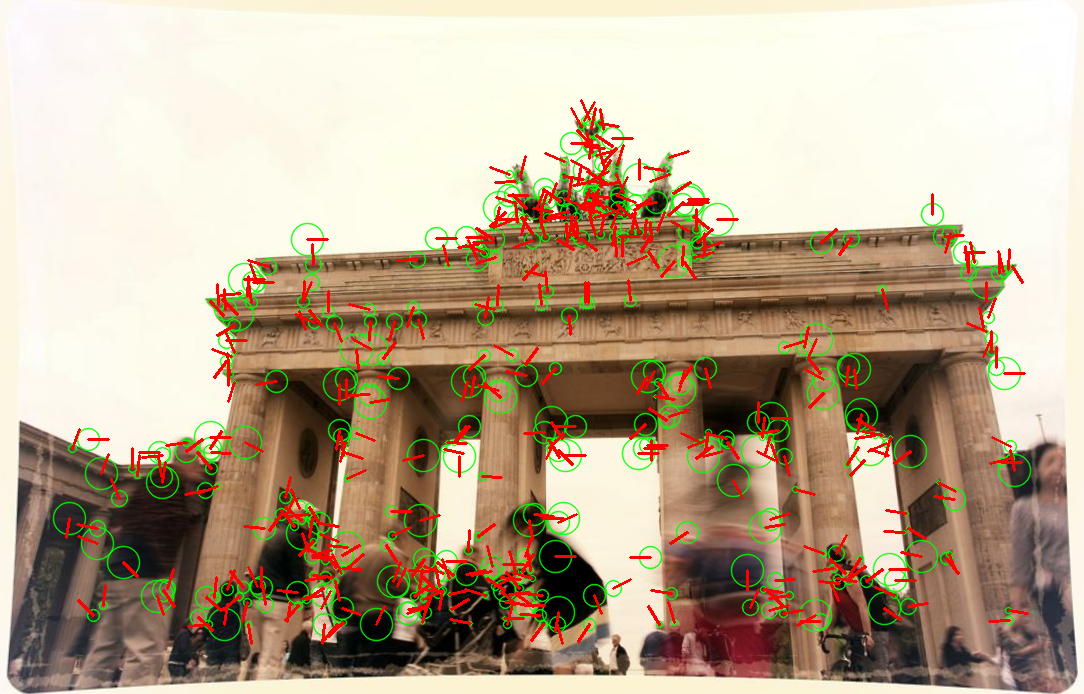

In [6]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def scale_space_peak_selection(image):
    scale_space = build_scale_space(image)
    keypoints = []

    for octave_index in range(len(scale_space)):
        for level in range(1, scale_space[octave_index].shape[0] - 1):
            neighbors = scale_space[octave_index][level - 1:level + 2, :, :]
            extremum_response = scale_space[octave_index][level, :, :] - np.max(neighbors, axis=0)
            extremum_locations = np.column_stack(np.where(extremum_response > 0))

            for location in extremum_locations:
                keypoints.append((octave_index, location[0], location[1]))

    return np.array(keypoints)

def build_scale_space(image, num_octaves=4, num_scales=5, sigma=1.6):
    scale_space = []

    for octave in range(num_octaves):
        octave_images = []

        if octave == 0:
            blurred = cv2.GaussianBlur(image, (0, 0), sigmaX=sigma)
        else:
            blurred = cv2.GaussianBlur(scale_space[octave - 1][0], (0, 0), sigmaX=sigma)

        octave_images.append(blurred)

        for _ in range(1, num_scales + 3):
            blurred = cv2.GaussianBlur(octave_images[-1], (0, 0), sigmaX=sigma)
            octave_images.append(blurred)

        scale_space.append(np.array(octave_images))
        image = cv2.resize(image, (image.shape[1] // 2, image.shape[0] // 2))

    return scale_space

def localize_keypoints(image, keypoints):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Crear STAR detector
    star = cv2.xfeatures2d.StarDetector_create()

    # Crear BRIEF extractor
    brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

    kp = star.detect(gray, None)

    kp, des = brief.compute(gray, kp)

    keypoint_locations = np.array([kp[idx].pt for idx in range(len(kp))], dtype=np.float32)

    img_keypoints = cv2.drawKeypoints(image, kp, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    return img_keypoints, keypoint_locations

def assign_orientation(image, keypoints):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Gradiente con Sobel operador
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    magnitude, angle = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)

    oriented_keypoints = []

    for keypoint in keypoints:
        x, y = int(keypoint[0]), int(keypoint[1])
        keypoint_angle = angle[y, x]
        oriented_keypoints.append((x, y, keypoint_angle))

    return oriented_keypoints

image = cv2.imread('image.jpg', cv2.IMREAD_COLOR)
keypoints = scale_space_peak_selection(image)
image_with_keypoints, refined_keypoint_locations = localize_keypoints(image, keypoints)
oriented_keypoints = assign_orientation(image, refined_keypoint_locations)

print("Oriented Keypoints:")
for keypoint in oriented_keypoints:
    print(f"X: {keypoint[0]}, Y: {keypoint[1]}, Orientation: {keypoint[2]} degrees")

for keypoint in oriented_keypoints:
    x, y = int(keypoint[0]), int(keypoint[1])
    angle = keypoint[2]
    cv2.line(image_with_keypoints, (x, y), (int(x + 20 * np.cos(np.radians(angle))), int(y + 20 * np.sin(np.radians(angle)))), (0, 0, 255), 2)

cv2_imshow(image_with_keypoints)